# Aspect-Based Sentiment Analysis - Movie Reviews

This project is a demonstration of aspect-based sentiment analysis (ABSA), specifically we analyze a dataset of movie reviews from the popular movie review website Letterboxd. The goal is to find a way to reliably detect a set of aspects that are assumed to be of importance when it comes to forming an opinion about a film and then associate polarities with these aspects.

Since there are well-known aspects in the art of film making that regularly come up in reviews or award shows, we don't try to extract aspects with unsupervised machine learning, but rather try to build a robust vocubalary for each pre-defined aspect that ideally covers synonyms and words related to this concept. Here the goal is to balance this keyword vocubalary so we don't over-generalize while still picking up all relevant mentions of the aspect.

This vocabulary is then used in conjunction with SpaCy and VADER to extract associated sentiments and analyze sentiment polarities.

## Data

In [219]:
import pandas as pd

# Read CSV data
df = pd.read_csv('letterboxd_250movie_reviews.csv').dropna()

# List of reviews
reviews = list(df['Review'])

## Aspect Detection

### WordNet (approach not used in final analysis)

In [220]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # For the extended WordNet data
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thomasmayr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/thomasmayr/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [221]:
# Define aspects
aspects = ['directing', 'music', 'story', 'acting', 'cinematography']

The code for the approach is only a part of what was tested using WordNet. Specifically, in the testing phase, various variations of the code below were considered, e.g. using all the synsets of an aspect label rather than only the most fitting one, using differenct combinations of semantic concepts, trying to filter words with WordNet's built in similarity measures and more. None of these approaches were particularly effective, therefore only the parts below were included here in the final report for demonstration purposes.

In [222]:
# Inspect each synset for each aspect in order to select appropriate synset
for aspect in aspects:
    synsets = wn.synsets(aspect)
    print("Aspect: ", aspect)
    print("")
    for syn in synsets:
        print("Synset name:  ", syn.name())             # Unique identifier
        print("Lemma names:  ", syn.lemma_names())      # List of synonymous words
        print("Definition:   ", syn.definition())       # Dictionary definition
        print("Examples:     ", syn.examples())         # Example usage
        print("-" * 60)
    print("")

Aspect:  directing

Synset name:   direct.v.01
Lemma names:   ['direct']
Definition:    command with authority
Examples:      ['He directed the children to do their homework']
------------------------------------------------------------
Synset name:   target.v.01
Lemma names:   ['target', 'aim', 'place', 'direct', 'point']
Definition:    intend (something) to move towards a certain goal
Examples:      ["He aimed his fists towards his opponent's face", 'criticism directed at her superior', 'direct your anger towards others, not towards yourself']
------------------------------------------------------------
Synset name:   direct.v.03
Lemma names:   ['direct']
Definition:    guide the actors in (plays and films)
Examples:      []
------------------------------------------------------------
Synset name:   direct.v.04
Lemma names:   ['direct']
Definition:    be in charge of
Examples:      []
------------------------------------------------------------
Synset name:   lead.v.01
Lemma names:  

In [ ]:
# Example aspects and respective synset for film reviews:
aspects_synsets = {
    "directing": "direct.v.03",
    "music": "music.n.01",
    "screenplay": "screenplay.n.01",
    "acting": "acting.n.01",
    "cinematography": "filming.n.01"
}

In [230]:
def get_related_words_to_synset(synset_name, pos=None):
    synset = wn.synset(synset_name, pos=pos) if pos else wn.synset(synset_name)
    results = set()
    # Add various related words using semantic concepts
    for lemma in synset.lemmas():
        results.add(lemma.name().lower())

    for hypernym in synset.hypernyms():
        for lemma in hypernym.lemmas():
            results.add(lemma.name().lower())

    for hyponym in synset.hyponyms():
        for lemma in hyponym.lemmas():
            results.add(lemma.name().lower())

    for part_meronyms in synset.part_meronyms():
        for lemma in part_meronyms.lemmas():
            results.add(lemma.name().lower())
    
    for substance_meronym in synset.substance_meronyms():
        for lemma in substance_meronym.lemmas():
            results.add(lemma.name().lower())

    for member_holonym in synset.member_holonyms():
        for lemma in member_holonym.lemmas():
            results.add(lemma.name().lower())

    return results


In [231]:
aspect_related_words = {}
for aspect, synset in aspects_synsets.items():
    aspect_related_words[aspect] = get_related_words_to_synset(synset)

In [232]:
print(aspect_related_words)

{'directing': {'make', 'direct', 'create', 'stage_direct'}, 'music': {'concerted_music', 'beethoven', 'polyphonic_music', 'strain', 'harmony', 'gilbert_and_sullivan', 'line', 'music', 'melodic_phrase', 'handel', 'chopin', 'dance_music', 'haydn', 'music_genre', 'refrain', 'instrumental_music', 'polyphony', 'polytonalism', 'monophony', 'popularism', 'composition', "ta'ziyeh", 'wagner', 'auditory_communication', 'tune', 'chorus', 'musical_style', 'musical_composition', 'air', 'melodic_line', 'syncopation', 'serial_music', 'bach', 'ballet', 'musical_harmony', 'pizzicato', 'brahms', 'monody', 'antiphony', 'polytonality', 'prelude', 'genre', 'mozart', 'piece', 'musical_genre', 'piece_of_music', 'monophonic_music', 'overture', 'vocal', 'vocal_music', 'opus', 'section', 'subdivision', 'serialism', 'part_music', 'stravinsky', 'melody'}, 'screenplay': {'book', 'playscript', 'screenplay', 'script'}, 'acting': {'portrayal', 'playacting', 'method_acting', 'business', 'byplay', 'performing_arts', 'm

### Word2Vec

In [ ]:
from gensim.utils import simple_preprocess

# Tokenize (simple)
tokenized_reviews = [simple_preprocess(review) for review in reviews]

In [ ]:
from gensim.models import Word2Vec

# Train a Word2Vec model
model = Word2Vec(
    tokenized_reviews,
    vector_size=150,
    window=5,
    min_count=10,
    workers=8
)

In [239]:
# Let's try to see if we can build a useful vocab with this method using some of the most similar (cosine similarity) for each aspect

# Query for words similar to "cinematography"
similar_to_cinematography = model.wv.most_similar("cinematography", topn=20)
print("Related to 'cinematography':")
for word, score in similar_to_cinematography:
    print(f"  {word}: {score}")

Related to 'cinematography':
  camerawork: 0.8307797312736511
  photography: 0.817209005355835
  visuals: 0.8078704476356506
  editing: 0.7470242977142334
  soundtrack: 0.7440069317817688
  animation: 0.7334676384925842
  direction: 0.7309778928756714
  scenery: 0.7044476866722107
  choreography: 0.6982153058052063
  lighting: 0.6926029920578003
  score: 0.6875585913658142
  costumes: 0.685419499874115
  design: 0.6833809018135071
  framing: 0.6731663942337036
  screenplay: 0.6638196706771851
  composition: 0.6605755090713501
  staging: 0.6566556096076965
  acting: 0.6463869214057922
  imagery: 0.6408823132514954
  script: 0.6406824588775635


#### Pruning candidates and building vocabularies

This method seems to capture a decent amount of words for an aspect but results can't be used directly since some words most similar to each aspect are too general or not appropriate.

We sort candidates by how frequently they appear in all reviews and manually select a set of candidiates for each aspect.

In [33]:
all_tokens = [item for sublist in tokenized_reviews for item in sublist]

In [34]:
from collections import Counter
token_counts = Counter(all_tokens)

In [49]:
# Query for words similar to "cinematography"
similar_to_cinematography = model.wv.most_similar("cinematography", topn=25)
print("Related to 'cinematography':")
cinematography_candidates = {}
for word, score in similar_to_cinematography:
    cinematography_candidates[word] = {'count': token_counts[word], 'similarity': score}
    # print(f"  {word} - count: {token_counts[word]}, similarity: {round(score, 2)}")
cinematography_candidates = dict(sorted(cinematography_candidates.items(), key=lambda x: x[1]["count"], reverse=True))
cinematography_candidates

Related to 'cinematography':


{'acting': {'count': 5427, 'similarity': 0.6463869214057922},
 'score': {'count': 5365, 'similarity': 0.6875585913658142},
 'direction': {'count': 3718, 'similarity': 0.7309778928756714},
 'script': {'count': 2804, 'similarity': 0.6406824588775635},
 'editing': {'count': 2742, 'similarity': 0.7470242977142334},
 'design': {'count': 2593, 'similarity': 0.6833809018135071},
 'animation': {'count': 2301, 'similarity': 0.7334676384925842},
 'gorgeous': {'count': 2031, 'similarity': 0.6309126615524292},
 'screenplay': {'count': 2010, 'similarity': 0.6638196706771851},
 'visuals': {'count': 1809, 'similarity': 0.8078704476356506},
 'soundtrack': {'count': 1672, 'similarity': 0.7440069317817688},
 'visually': {'count': 1640, 'similarity': 0.6327150464057922},
 'imagery': {'count': 1345, 'similarity': 0.6408823132514954},
 'breathtaking': {'count': 1118, 'similarity': 0.6260013580322266},
 'lighting': {'count': 1102, 'similarity': 0.6926029920578003},
 'camerawork': {'count': 962, 'similarity'

In [72]:
vocab_cinematography = ['visuals', 'imagery', 'lighting', 'camerawork', 'framing', 'photography', 'composition', 'scenery', 'choreography']

In [55]:
aspect = "direction"
similar_words = model.wv.most_similar(aspect, topn=25)
print(f"Related to '{aspect}':")
candidates = {}
for word, score in similar_words:
    candidates[word] = {'count': token_counts[word], 'similarity': round(score, 2)}
candidates = dict(sorted(candidates.items(), key=lambda x: x[1]["count"], reverse=True))
candidates

Related to 'direction':


{'work': {'count': 12571, 'similarity': 0.57},
 'performances': {'count': 7668, 'similarity': 0.59},
 'cinematography': {'count': 6729, 'similarity': 0.73},
 'acting': {'count': 5427, 'similarity': 0.71},
 'score': {'count': 5365, 'similarity': 0.57},
 'writing': {'count': 3202, 'similarity': 0.65},
 'filmmaking': {'count': 3094, 'similarity': 0.6},
 'script': {'count': 2804, 'similarity': 0.7},
 'editing': {'count': 2742, 'similarity': 0.68},
 'design': {'count': 2593, 'similarity': 0.55},
 'storytelling': {'count': 2532, 'similarity': 0.63},
 'pacing': {'count': 2087, 'similarity': 0.56},
 'screenplay': {'count': 2010, 'similarity': 0.71},
 'visuals': {'count': 1809, 'similarity': 0.59},
 'directing': {'count': 1231, 'similarity': 0.74},
 'craft': {'count': 1041, 'similarity': 0.58},
 'camerawork': {'count': 962, 'similarity': 0.68},
 'framing': {'count': 879, 'similarity': 0.58},
 'execution': {'count': 797, 'similarity': 0.6},
 'photography': {'count': 701, 'similarity': 0.58},
 'i

In [73]:
vocab_direction = ['filmmaking', 'directing']
manual_additions = ['director', 'filmmaker']
vocab_direction.extend(manual_additions)

In [60]:
aspect = "music"
similar_words = model.wv.most_similar(aspect, topn=25)
print(f"Related to '{aspect}':")
candidates = {}
for word, score in similar_words:
    candidates[word] = {'count': token_counts[word], 'similarity': round(score, 2)}
candidates = dict(sorted(candidates.items(), key=lambda x: x[1]["count"], reverse=True))
candidates

Related to 'music':


{'cinematography': {'count': 6729, 'similarity': 0.6},
 'score': {'count': 5365, 'similarity': 0.76},
 'dialogue': {'count': 4476, 'similarity': 0.58},
 'sound': {'count': 3732, 'similarity': 0.56},
 'editing': {'count': 2742, 'similarity': 0.62},
 'animation': {'count': 2301, 'similarity': 0.58},
 'visuals': {'count': 1809, 'similarity': 0.52},
 'soundtrack': {'count': 1672, 'similarity': 0.79},
 'song': {'count': 1424, 'similarity': 0.6},
 'musical': {'count': 1301, 'similarity': 0.66},
 'background': {'count': 1254, 'similarity': 0.57},
 'lighting': {'count': 1102, 'similarity': 0.61},
 'colors': {'count': 971, 'similarity': 0.52},
 'camerawork': {'count': 962, 'similarity': 0.59},
 'framing': {'count': 879, 'similarity': 0.53},
 'photography': {'count': 701, 'similarity': 0.55},
 'narration': {'count': 560, 'similarity': 0.59},
 'songs': {'count': 494, 'similarity': 0.62},
 'piano': {'count': 447, 'similarity': 0.57},
 'blocking': {'count': 434, 'similarity': 0.52},
 'classical': {

In [74]:
vocab_music = ['score', 'sound', 'soundtrack', 'song', 'musical', 'songs', 'piano']

In [63]:
aspect = "acting"
similar_words = model.wv.most_similar(aspect, topn=25)
print(f"Related to '{aspect}':")
candidates = {}
for word, score in similar_words:
    candidates[word] = {'count': token_counts[word], 'similarity': round(score, 2)}
candidates = dict(sorted(candidates.items(), key=lambda x: x[1]["count"], reverse=True))
candidates

Related to 'acting':


{'performance': {'count': 8338, 'similarity': 0.64},
 'performances': {'count': 7668, 'similarity': 0.74},
 'cinematography': {'count': 6729, 'similarity': 0.65},
 'dialogue': {'count': 4476, 'similarity': 0.55},
 'cast': {'count': 4337, 'similarity': 0.61},
 'direction': {'count': 3718, 'similarity': 0.71},
 'actors': {'count': 3676, 'similarity': 0.57},
 'writing': {'count': 3202, 'similarity': 0.65},
 'filmmaking': {'count': 3094, 'similarity': 0.54},
 'script': {'count': 2804, 'similarity': 0.62},
 'editing': {'count': 2742, 'similarity': 0.62},
 'excellent': {'count': 2614, 'similarity': 0.53},
 'animation': {'count': 2301, 'similarity': 0.54},
 'pacing': {'count': 2087, 'similarity': 0.53},
 'screenplay': {'count': 2010, 'similarity': 0.63},
 'visuals': {'count': 1809, 'similarity': 0.53},
 'phenomenal': {'count': 1793, 'similarity': 0.55},
 'directing': {'count': 1231, 'similarity': 0.7},
 'camerawork': {'count': 962, 'similarity': 0.57},
 'chemistry': {'count': 867, 'similarity

In [75]:
vocab_acting = ['performance', 'performances', 'cast', 'actors', 'chemistry', 'ensemble', 'casting']
manual_additions = ['actor', 'actress', 'performer']
vocab_acting.extend(manual_additions)

In [69]:
aspect = "plot"
similar_words = model.wv.most_similar(aspect, topn=25)
print(f"Related to '{aspect}':")
candidates = {}
for word, score in similar_words:
    candidates[word] = {'count': token_counts[word], 'similarity': round(score, 2)}
candidates = dict(sorted(candidates.items(), key=lambda x: x[1]["count"], reverse=True))
candidates

Related to 'plot':


{'story': {'count': 23534, 'similarity': 0.74},
 'narrative': {'count': 5256, 'similarity': 0.78},
 'dialogue': {'count': 4476, 'similarity': 0.61},
 'script': {'count': 2804, 'similarity': 0.58},
 'storytelling': {'count': 2532, 'similarity': 0.5},
 'pacing': {'count': 2087, 'similarity': 0.53},
 'series': {'count': 2023, 'similarity': 0.47},
 'screenplay': {'count': 2010, 'similarity': 0.51},
 'structure': {'count': 1595, 'similarity': 0.55},
 'engaging': {'count': 1437, 'similarity': 0.49},
 'mystery': {'count': 1427, 'similarity': 0.59},
 'concept': {'count': 1356, 'similarity': 0.5},
 'pace': {'count': 1212, 'similarity': 0.47},
 'twist': {'count': 1023, 'similarity': 0.47},
 'premise': {'count': 843, 'similarity': 0.73},
 'melodrama': {'count': 795, 'similarity': 0.48},
 'thematic': {'count': 783, 'similarity': 0.49},
 'intriguing': {'count': 750, 'similarity': 0.47},
 'narration': {'count': 560, 'similarity': 0.54},
 'storyline': {'count': 555, 'similarity': 0.77},
 'exposition'

In [76]:
vocab_story = ['narrative', 'plot', 'script', 'storytelling', 'screenplay', 'storyline']
manual_additions = ['dialogue', 'writing', 'dialogues', 'narration', 'plotline']
vocab_story.extend(manual_additions)

### Final Vocabulary

In [158]:
vocab = {
    'direction': vocab_direction,
    'story': vocab_story,
    'acting': vocab_acting,
    'cinematography': vocab_cinematography,
    'music': vocab_music
}

# Adding the aspect label to the vocab of itself
for (aspect_label, keywords) in vocab.items():
    keywords.append(aspect_label)

### Evaluation and comparison of internal coherence of final vocabularies

We would like some measures to evaluate and compare the interal coherence and consistency of our vocabularies.

In [ ]:
# A function for getting the average cosine similarities between words in a vocabulary
def compute_average_similarity(vocabulary, model):
    similarities = []
    for i, word1 in enumerate(vocabulary):
        for word2 in vocabulary[i + 1:]:
            if word1 in model.wv.key_to_index and word2 in model.wv.key_to_index:
                similarity = model.wv.similarity(word1, word2)
                similarities.append(similarity)
    return sum(similarities) / len(similarities) if similarities else None

for (aspect_label, words) in vocab.items():

    print(f'{aspect_label}: {round(compute_average_similarity(words, model), 3)}')

direction: 0.526
story: 0.529
acting: 0.512
cinematography: 0.718
music: 0.532


### Visualisations for vocabularies

In [172]:
# Adding counts to our vocabs
vocab_with_counts = vocab.copy()

for aspect, aspect_vocab in vocab_with_counts.items():
    vocab_with_counts[aspect] = {word: token_counts[word] for word in aspect_vocab}

print(vocab_with_counts)

{'direction': {'filmmaking': 3094, 'directing': 1231, 'director': 7047, 'filmmaker': 1772, 'direction': 3718}, 'story': {'narrative': 5256, 'plot': 5241, 'script': 2804, 'storytelling': 2532, 'screenplay': 2010, 'storyline': 555, 'dialogue': 4476, 'writing': 3202, 'dialogues': 593, 'narration': 560, 'plotline': 71, 'story': 23534}, 'acting': {'performance': 8338, 'performances': 7668, 'cast': 4337, 'actors': 3676, 'chemistry': 867, 'ensemble': 579, 'casting': 556, 'actor': 3066, 'actress': 1355, 'performer': 173, 'acting': 5427}, 'cinematography': {'visuals': 1809, 'imagery': 1345, 'lighting': 1102, 'camerawork': 962, 'framing': 879, 'photography': 701, 'composition': 645, 'scenery': 329, 'choreography': 297, 'cinematography': 6729}, 'music': {'score': 5365, 'sound': 3732, 'soundtrack': 1672, 'song': 1424, 'musical': 1301, 'songs': 494, 'piano': 447, 'music': 5251}}


In [ ]:
# Building the appropriate data frame for our visualisations
rows = []
for aspect, word_freqs in vocab_with_counts.items():
    for word, frequency in word_freqs.items():
        rows.append({'Aspect': aspect, 'Word': word, 'Frequency': frequency})

df = pd.DataFrame(rows)

In [180]:
import plotly.express as px

# Create a sunburst plot using Plotly Express
fig = px.sunburst(
    df,
    path=['Aspect', 'Word'],
    values='Frequency',
    color='Aspect',
)

# Styling
fig.update_layout(
    margin=dict(t=25, l=25, r=25, b=25),
    uniformtext=dict(minsize=10)
)

fig.show()


In [ ]:
# Function for generating a latex table for aspection vocabularies
# Lists all words and corresponding frequencies
# Additoinally lists total frequencies for each aspect

def generate_latex_table_with_totals(aspect_data):

    latex_str = r"""
\begin{table}[htbp]
\centering
\begin{tabular}{llcc}
\toprule
\textbf{Aspect} & \textbf{Word} & \textbf{Frequency} & \textbf{Total} \\
\midrule
"""

    # Sort aspects for consistent order
    all_aspects = sorted(aspect_data.keys())

    for aspect in all_aspects:
        words_freqs = aspect_data[aspect]
        # Convert the dictionary items into a list
        items = list(words_freqs.items())
        row_count = len(items)

        # Compute the sum of frequencies for this aspect
        aspect_total = sum(words_freqs.values())

        # First row in block, we print aspect name and the aspect total in the same row
        first_word, first_freq = items[0]
        latex_str += (
            f"\\multirow{{{row_count}}}{{*}}{{{aspect}}} & "
            f"{first_word} & "
            f"{first_freq} & "
            f"\\multirow{{{row_count}}}{{*}}{{{aspect_total}}} \\\\ \n"
        )

        # Subsequent rows for this aspect
        for j in range(1, row_count):
            word, freq = items[j]
            latex_str += f"& {word} & {freq} & \\\\ \n"

        # Add midrule after each aspect group
        latex_str += r"\midrule" + "\n"

    # Finish table
    latex_str += r"""\bottomrule
\end{tabular}
\caption{Vocabulary words, individual frequencies, and total frequencies per aspect.}
\label{tab:aspect-freq-totals}
\end{table}
"""

    return latex_str


In [188]:
# Print for copying into LaTeX
print(generate_latex_table_with_totals(vocab_with_counts))


\begin{table}[htbp]
\centering
\begin{tabular}{llcc}
\toprule
\textbf{Aspect} & \textbf{Word} & \textbf{Frequency} & \textbf{Total} \\
\midrule
\multirow{11}{*}{acting} & performance & 8338 & \multirow{11}{*}{36042} \\ 
& performances & 7668 & \\ 
& cast & 4337 & \\ 
& actors & 3676 & \\ 
& chemistry & 867 & \\ 
& ensemble & 579 & \\ 
& casting & 556 & \\ 
& actor & 3066 & \\ 
& actress & 1355 & \\ 
& performer & 173 & \\ 
& acting & 5427 & \\ 
\midrule
\multirow{10}{*}{cinematography} & visuals & 1809 & \multirow{10}{*}{14798} \\ 
& imagery & 1345 & \\ 
& lighting & 1102 & \\ 
& camerawork & 962 & \\ 
& framing & 879 & \\ 
& photography & 701 & \\ 
& composition & 645 & \\ 
& scenery & 329 & \\ 
& choreography & 297 & \\ 
& cinematography & 6729 & \\ 
\midrule
\multirow{5}{*}{direction} & filmmaking & 3094 & \multirow{5}{*}{16862} \\ 
& directing & 1231 & \\ 
& director & 7047 & \\ 
& filmmaker & 1772 & \\ 
& direction & 3718 & \\ 
\midrule
\multirow{8}{*}{music} & score & 5365 & \mu

## Sentiment Analysis

Now we try to use our vocabs to detect aspects and associate sentiments. We use SpaCy and VADER for this.

In [ ]:
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

nlp = spacy.load("en_core_web_lg")
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/thomasmayr/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [107]:
def find_aspect_tokens(doc, aspect_dict):
    """
    Return a list of (aspect_token, aspect_label) in the doc by matching spaCy tokens to the aspect dictionary.
    """
    aspect_tokens = []
    for token in doc:
        token_lower = token.text.lower()
        for aspect_label, keywords in aspect_dict.items():
            if token_lower in keywords or token_lower == aspect_label:
                aspect_tokens.append((token, aspect_label))
    return aspect_tokens


In [ ]:
def extract_opinion_phrase(aspect_token):
    """
    Return a short text chunk (string) that includes:
      - the aspect token itself
      - any opinion words directly modifying it
      - if the aspect token is the subject of a linking verb (e.g. 'are', 'is'), then look for so called adjectival complements of that verb.
      - check for negations as well
    """
    phrase_tokens = [aspect_token.text]

    # Check immediate children for adjectives, adverbs, or negations
    for child in aspect_token.children:
        if child.pos_ in ("ADJ", "ADV"):
            phrase_tokens.append(child.text)
        if child.dep_ == "neg":
            phrase_tokens.append(child.text)
    
    # Check the token’s head (= parent)
    head = aspect_token.head
    if head != aspect_token:
        # If aspect is a subject (nsubj) of a verb (often a linking verb)
        if aspect_token.dep_ == "nsubj":
            # If the head is a linking verb (e.g., 'is', 'are')
            # Look for adjectival complements of that verb
            if head.lemma_ in {"be", "seem", "appear", "become", "feel"}:
                # Check children of the head
                for child in head.children:
                    # Adjectival complement
                    if child.dep_ == "acomp" and child.pos_ == "ADJ":
                        phrase_tokens.append(child.text)
                        # Also look for negations in the child's children
                        for subchild in child.children:
                            if subchild.dep_ == "neg":
                                phrase_tokens.append(subchild.text)

                    # Negation directly under head verb
                    if child.dep_ == "neg":
                        phrase_tokens.append(child.text)

        # If the head is an ADJ/ADV describing the aspect (or a sentiment verb like "love"/"hate")
        if head.pos_ in ("ADJ", "ADV"):
            phrase_tokens.append(head.text)
            for subchild in head.children:
                if subchild.dep_ == "neg":
                    phrase_tokens.append(subchild.text)

        # If the head is a sentiment verb (e.g., "love", "hate")
        if head.pos_ == "VERB" and head.lemma_.lower() in {"love", "hate", "like", "dislike", "enjoy"}:
            phrase_tokens.append(head.text)
            for subchild in head.children:
                if subchild.dep_ == "neg":
                    phrase_tokens.append(subchild.text)
    
    # Convert list to a single string
    return " ".join(phrase_tokens)


In [ ]:
def analyze_aspects_vader_dependency(sentence, aspect_dict, sia):
    doc = nlp(sentence)
    
    aspect_token_list = find_aspect_tokens(doc, aspect_dict)
    
    aspect_sentiments = {}
    for aspect_token, aspect_label in aspect_token_list:
        # Extract the local opinion phrase
        opinion_chunk = extract_opinion_phrase(aspect_token)
        
        # Pass it to VADER
        scores = sia.polarity_scores(opinion_chunk)
        compound = scores['compound']
        
        # Determine polarity label from compound
        if compound >= 0.05:
            polarity = "positive"
        elif compound <= -0.05:
            polarity = "negative"
        else:
            polarity = "neutral"
        
        # Merge results if the aspect_label appears multiple times
        if aspect_label in aspect_sentiments:
            # For simplicity, if we see any "negative", override; 
            # else if we see "positive" and it was "neutral", override, etc.
            existing = aspect_sentiments[aspect_label]
            if existing == "negative" or polarity == "negative":
                aspect_sentiments[aspect_label] = ("negative", compound)
            elif existing == "neutral" and polarity == "positive":
                aspect_sentiments[aspect_label] = ("positive", compound)
            # else, keep the existing
        else:
            aspect_sentiments[aspect_label] = (polarity, compound)
    
    return aspect_sentiments


In order to see the capabilities of our sentiment detector we examine a review on a sentence-level.

In [120]:
test_sentences = nltk.sent_tokenize(df['Review'][9999])

for sentence in test_sentences:
    result = analyze_aspects_vader_dependency(sentence, vocab, sia)
    print(f"Sentence: {sentence}")
    print(f"Aspect Sentiments: {result}")
    print("---")

Sentence: A brilliantly bleak portrait of capitalism, There Will Be Blood uses perfect performances to demonstrate that greed corrupts everyone, regardless of nobility or intentions.
Aspect Sentiments: {'acting': ('positive', 0.5719)}
---
Sentence: Plainview is the quintessential capitalist — he’ll put up any moral front to trick people into supporting his endeavors, he screws over everyone if it means making more money, and he only wants to become wealthy for the hell of it.
Aspect Sentiments: {}
---
Sentence: He’ll kill a man, destroy a town, and disown his own son to make an extra dime.
Aspect Sentiments: {}
---
Sentence: And Anderson utilizes the perfect industry — oil drilling — for Plainview, as it’s incredibly dangerous for the boots on the ground, it absolutely destroys existing ecosystems, it disrupts communities, and it makes its investors very, very rich.
Aspect Sentiments: {}
---
Sentence: I’m not sure if any other business model could better embody the horrors of capitalis

### Analysis on a review level rather than individual sentences

Instead of individual sentences we are more interested in capturing aspect sentiment for the entire review.

In [ ]:
from collections import defaultdict

def analyze_aspects_in_review(review_text, aspect_dict, sia):
    """
    Analyze an entire review (which can be multiple sentences).
    Returns a dict: {aspect_label: (polarity, avg_compound_score)}.
    
    - aspect_dict: dictionary mapping aspect labels to list of aspect keywords
    - nlp: spaCy language model
    - sia: VADER's SentimentIntensityAnalyzer instance
    """
    # 1. Parse the entire review (not just a single sentence)
    doc = nlp(review_text)

    # 2. Find aspect tokens across the whole doc
    aspect_token_list = find_aspect_tokens(doc, aspect_dict)
    
    # We'll store all compound scores for each aspect label
    aspect_score_map = defaultdict(list)
    
    # 3. For each aspect token, extract the local opinion phrase and get VADER score
    for aspect_token, aspect_label in aspect_token_list:
        # Extract local opinion phrase around this aspect token
        opinion_chunk = extract_opinion_phrase(aspect_token)
        
        # Use VADER on this chunk
        scores = sia.polarity_scores(opinion_chunk)
        compound = scores["compound"]
        
        # Add the compound score to our tracking for this aspect_label
        aspect_score_map[aspect_label].append(compound)
    
    # 4. Aggregate scores for each aspect
    aspect_sentiments = {}
    for aspect_label, compound_list in aspect_score_map.items():
        if not compound_list:
            # No actual scores for some reason (shouldn't happen unless no opinion found)
            aspect_sentiments[aspect_label] = ("neutral", 0.0)
        else:
            # Average compound scores
            avg_compound = sum(compound_list) / len(compound_list)
            
            # Turn the averaged score into a polarity label
            if avg_compound >= 0.05:
                polarity = "positive"
            elif avg_compound <= -0.05:
                polarity = "negative"
            else:
                polarity = "neutral"
            
            # Store final label + the average compound score
            aspect_sentiments[aspect_label] = (polarity, avg_compound)
    
    return aspect_sentiments


In [ ]:
# Let's see some output for an entire test review 
test_review = df['Review'][50000]

result = analyze_aspects_in_review(test_review, vocab, sia)
print(f"Review: {test_review}")
print(f"Aspect Sentiments: {result}")
print("---")

Sentence: this is the movie.this is the best crime movie, best mystery movie, best period drama, best noir movie, best comedy, best 70s movie, best original soundtrack, best original screenplay, and best acting. so much has already been said about its greatness so i’m just gonna talk about what it means to me personally. what makes this movie stand out is its message. it holds a greater, more powerful message than any other classic movie, the obvious one being that power is evil and the police are corrupt, but the more powerful message to me is: people often don’t understand or underestimate the trauma and depth a woman has under the surface. evelyn is painted as an evil, mysterious “femme fatale” who is hiding her infidelity and demise of her husband. what we don’t know until the end is that it was her own father who, not only killed her husband, but raped her when she was a child. every time her father is brought up she gets visibly uncomfortable. when jj asks her about katherine in 

Now let's process our entire corpus of reviews (this takes a while).

In [137]:
aspect_sentiments = []
for review in df['Review']:
    result = analyze_aspects_in_review(review, vocab, sia)
    aspect_sentiments.append(result)

In [ ]:
import collections

aspect_counts = collections.Counter()
aspect_sentiment_sums = collections.Counter()

for review in aspect_sentiments:
    for aspect, (label, score) in review.items():
        aspect_counts[aspect] += 1
        aspect_sentiment_sums[aspect] += score

# Now we can compute average sentiment for each aspect for the entire corpus
average_sentiment = {}
for aspect in aspect_counts:
    avg_score = aspect_sentiment_sums[aspect] / aspect_counts[aspect]
    average_sentiment[aspect] = avg_score

print("Mentions:", aspect_counts)
print("Avg sentiment:", average_sentiment)


Mentions: Counter({'story': 24901, 'acting': 19130, 'direction': 11953, 'music': 11884, 'cinematography': 10805})
Avg sentiment: {'story': 0.05685221652402305, 'direction': 0.07294951815597542, 'music': 0.07449219633410609, 'cinematography': 0.1497486406789069, 'acting': 0.16015671368701406}


### Visualisations

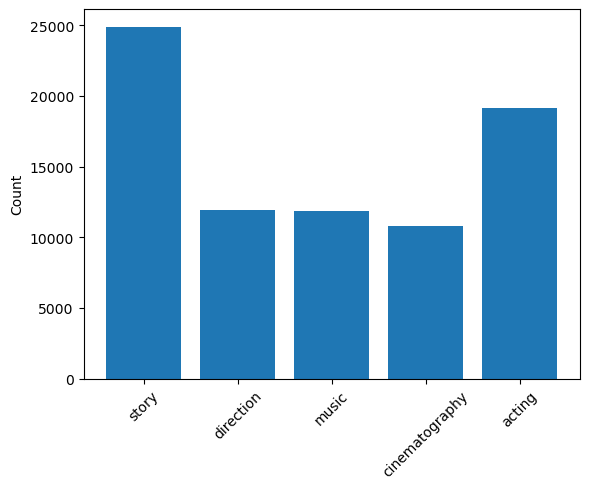

In [ ]:
import matplotlib.pyplot as plt

aspects = list(aspect_counts.keys())
counts = [aspect_counts[a] for a in aspects]

plt.bar(aspects, counts)
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


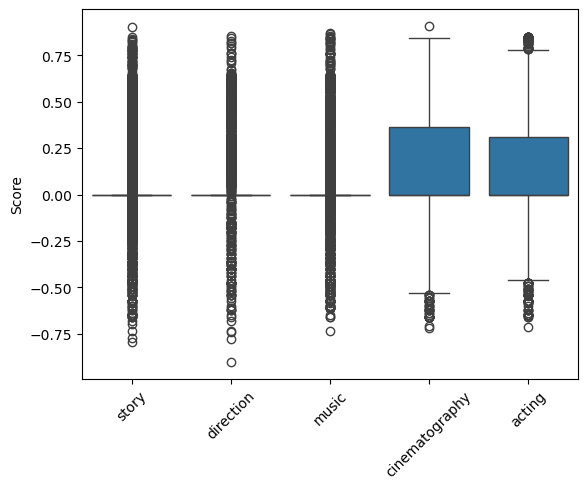

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gather scores in a dict of lists
scores_by_aspect = collections.defaultdict(list)

for review in aspect_sentiments:
    for aspect, (label, score) in review.items():
        scores_by_aspect[aspect].append(score)

# DataFrame for seaborn plotting
import pandas as pd

rows = []
for aspect, score_list in scores_by_aspect.items():
    for sc in score_list:
        rows.append((aspect, sc))
df_scores = pd.DataFrame(rows, columns=["Aspect", "Score"])

# Boxplot of scores by aspect
sns.boxplot(data=df_scores, x="Aspect", y="Score")
plt.xlabel("")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from collections import defaultdict

count_by_aspect = defaultdict(lambda: {'positive': 0, 'neutral': 0, 'negative': 0})

for review in aspect_sentiments:
    for aspect, (label, score) in review.items():
        count_by_aspect[aspect][label] += 1


In [ ]:
import matplotlib.pyplot as plt

# Convert dictionary keys to list for plotting
aspects = list(count_by_aspect.keys())
positives = [count_by_aspect[a]['positive'] for a in aspects]
neutrals  = [count_by_aspect[a]['neutral']  for a in aspects]
negatives = [count_by_aspect[a]['negative'] for a in aspects]


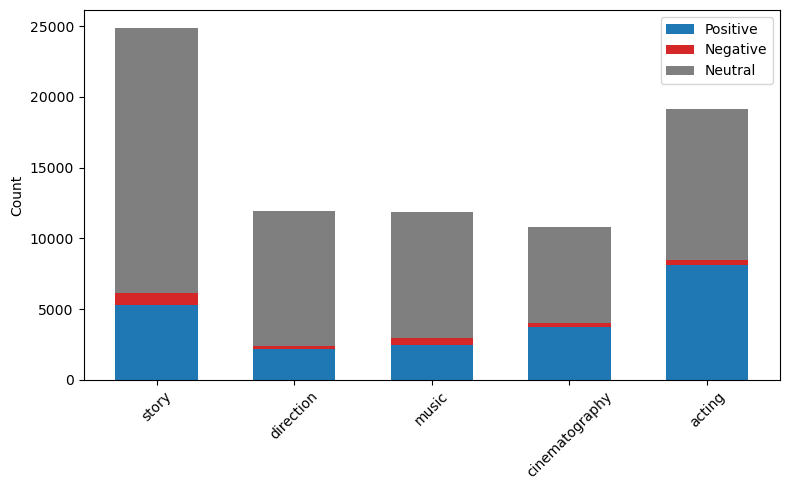

In [ ]:
bar_width = 0.6
fig, ax = plt.subplots(figsize=(8, 5))

# Plot positive bars first (bottom = 0)
ax.bar(aspects, positives, bar_width, label='Positive', color='tab:blue')

# Plot negative bars on top of positives
bottom_for_negatives = positives
ax.bar(aspects, negatives, bar_width,
       bottom=bottom_for_negatives,
       label='Negative', color='tab:red')

# Plot neutral bars on top of both positives and negatives
bottom_for_neutrals = [p + n for p, n in zip(positives, negatives)]
ax.bar(aspects, neutrals, bar_width,
       bottom=bottom_for_neutrals,
       label='Neutral', color='tab:gray')

ax.set_ylabel('Count')
ax.set_xticks(range(len(aspects)))
ax.set_xticklabels(aspects, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()
